# Seeds Classification

Dataset source: [Kaggle](https://www.kaggle.com/datasets/dongeorge/seed-from-uci)

Features:                                            
area A,
perimeter P,
compactness C = 4piA/P^2,
length of kernel,
width of kernel,
asymmetry coefficient
length of kernel groove.

Target:                                
3 classes

## Dataset analysis

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("dongeorge/seed-from-uci")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 3.71k/3.71k [00:00<00:00, 6.51MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dongeorge/seed-from-uci/versions/1
['Seed_Data.csv']


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

url = path + '/Seed_Data.csv'
df = pd.read_csv(url)

target_column = "target"
print(df.isnull().sum())

A         0
P         0
C         0
LK        0
WK        0
A_Coef    0
LKG       0
target    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       210 non-null    float64
 1   P       210 non-null    float64
 2   C       210 non-null    float64
 3   LK      210 non-null    float64
 4   WK      210 non-null    float64
 5   A_Coef  210 non-null    float64
 6   LKG     210 non-null    float64
 7   target  210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB


In [ ]:
print(df.shape)
df.head(6)

(210, 8)


,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,0


Analyzing each feature

In [ ]:
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
A,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
P,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
C,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
LK,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
WK,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
A_Coef,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
LKG,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500
target,210.0,1.000000,0.818448,0.0000,0.00000,1.00000,2.000000,2.0000


Creating correlation matrix

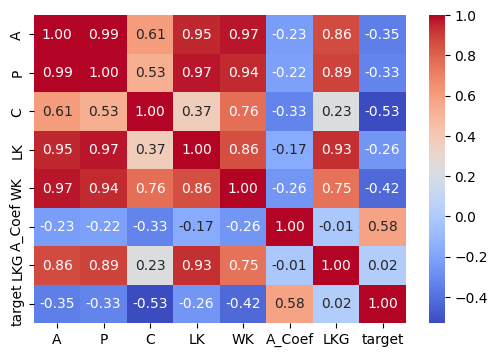

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## Logistic regression

Function for scaling

In [ ]:
def standard_scale(X):
    X = np.array(X, dtype=float)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    eps = 1e-10
    X_scaled = (X - mean) / (std + eps)
    return X_scaled, mean, std

Class for logistic regression (One-Rest)

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, max_iter=100000, tol=1e-6, reg_lambda=1.0):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.reg_lambda = reg_lambda
        self.coef = None
        self.cost = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.coef = np.zeros((n_classes, n_features))
        self.cost = []

        for idx, cls in enumerate(self.classes):
            y_binary = (y == cls).astype(int).reshape(-1, 1)
            coef_cls = np.zeros((n_features, 1))
            cost_cls = []

            for it in range(self.max_iter):
                y_pred = self.sigmoid(X @ coef_cls)
                grad = (X.T @ (y_pred - y_binary)) / n_samples + self.reg_lambda * coef_cls / n_samples
                coef_cls -= self.lr * grad

                loss = -np.mean(
                    y_binary * np.log(y_pred + 1e-12) + (1 - y_binary) * np.log(1 - y_pred + 1e-12)
                ) + (self.reg_lambda / (2 * n_samples)) * np.sum(coef_cls ** 2)

                cost_cls.append(loss)

                if np.linalg.norm(grad) < self.tol:
                    break

            self.coef[idx] = coef_cls.flatten()
            self.cost.append(cost_cls)

    def predict_proba(self, X):
        probs = self.sigmoid(X @ self.coef.T)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]


Metrics for classification

In [ ]:
def accuracy_manual(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    return np.mean(y_true == y_pred)

def precision_manual(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    classes = np.unique(y_true)
    precisions = []
    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    return np.mean(precisions)

def recall_manual(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def f1_score_manual(y_true, y_pred):
    p = precision_manual(y_true, y_pred)
    r = recall_manual(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

def classification_metrics_manual(y_true, y_pred):
    return {
        'Accuracy': accuracy_manual(y_true, y_pred),
        'Precision': precision_manual(y_true, y_pred),
        'Recall': recall_manual(y_true, y_pred),
        'F1-score': f1_score_manual(y_true, y_pred)
    }


In [ ]:
def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    cm = np.zeros((n_classes, n_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        i = class_to_idx[true]
        j = class_to_idx[pred]
        cm[i, j] += 1
    return cm, classes

Splitting data for cross-validation

In [ ]:
def cv_split(n_samples, n_splits=5,random_state=None):
    indices = np.arange(n_samples)

    rg = np.random.default_rng(seed=random_state)
    rg.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    for fold_size in fold_sizes:
        test_idx = indices[current:current+fold_size]
        train_idx = np.concatenate((indices[:current], indices[current+fold_size:]))
        yield train_idx, test_idx
        current += fold_size


Training and evaluating

General metrics:
Train metrics: {'Accuracy': 0.973, 'Precision': 0.973, 'Recall': 0.973, 'F1-score': 0.973}
Test metrics: {'Accuracy': 0.962, 'Precision': 0.96, 'Recall': 0.966, 'F1-score': 0.963}


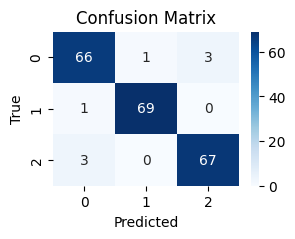

In [ ]:
X = df.drop(columns=[target_column])
y = df[target_column]

X_scaled = standard_scale(X)[0]
y = np.array(y, dtype=int).flatten()

n_features = X_scaled.shape[1]
X_scaled = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))

metrics_train_all, metrics_test_all = [], []
cm_total = None

for train_idx, test_idx in cv_split(X_scaled.shape[0], n_splits=5, random_state=42):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression(lr=0.01, reg_lambda=0.01)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    metrics_train_all.append(classification_metrics_manual(y_train.flatten(), y_train_pred.flatten()))
    metrics_test_all.append(classification_metrics_manual(y_test.flatten(), y_test_pred.flatten()))

    cm_fold, classes = confusion_matrix(y_test.flatten(), y_test_pred.flatten())
    if cm_total is None:
        cm_total = cm_fold
    else:
        cm_total += cm_fold

avg_metrics_train = {k: round(float(np.mean([m[k] for m in metrics_train_all])), 3) for k in metrics_train_all[0]}
avg_metrics_test = {k: round(float(np.mean([m[k] for m in metrics_test_all])), 3) for k in metrics_test_all[0]}

print("General metrics:")
print("Train metrics:", avg_metrics_train)
print("Test metrics:", avg_metrics_test)

plt.figure(figsize=(3, 2))
sns.heatmap(cm_total, annot=True, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
